In [1]:
from z3 import *
from sklearn.datasets import make_blobs

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import itertools
import time

# Data Generation

In [3]:
NUM_FEATURES = 2
NUM_CLASSES = 3

COLORS = np.array(list(mcolors.TABLEAU_COLORS.keys()))

In [4]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES)

In [5]:
def plot(x, y):
  plt.scatter(*x.T, color=COLORS[y])

def plot_boundry(x, y, model, h=0.01, alpha=0.5):
  x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
  y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  z = model(np.vstack([xx.ravel(), yy.ravel()]).T)
  z = z.reshape(xx.shape)
  plt.contourf(xx, yy, z, levels=list(range(-1, NUM_CLASSES)), colors=COLORS, alpha=alpha)

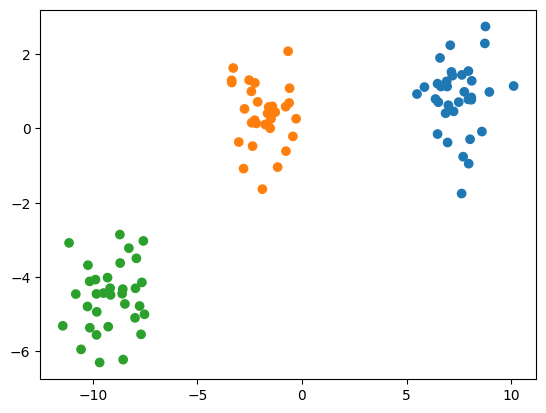

In [6]:
plot(X, y)

# Misc 

In [7]:
def quantize_X(x, b=8):
    
    xq = x.copy()
    xd = x.copy()
    for i in range(x.shape[1]):
        s=(2**b-1)/abs(np.max(x,axis=0)[i])
        xq[:,i] = np.round(s*x[:,i])
        xd[:,i] = xq[:,i]/s

    return xq, xd

# z-threeml

In [8]:
def get_value(x):
  if is_int_value(x):
    return x.as_long()
  if is_rational_value(x):
    return x.numerator_as_long() / x.denominator_as_long()
  if is_algebraic_value(x):
    return x.approx()
  raise ValueError(f"I don't know what {x} is")

def argmax(logits, ix, max_val):
    # Based on http://www.hakank.org/z3/argmax.py
    terms = []
    terms.append(Or([max_val == logits[i] for i in range(len(logits))]))
    for i in range(len(logits)):
        terms.append((ix == i) == (logits[i] == max_val))
    return terms

def maximum(logits, max_val):
    # Based on http://www.hakank.org/z3/max.py
    terms = []
    terms.append(Or([max_val == logits[i] for i in range(len(logits))]))
    for i in range(len(logits)):
        terms.append(max_val >= logits[i])
    return terms

In [9]:
class z3Linear:
  def __init__(self, n_features, dtype=Real):
    self.w = np.array([dtype(f"w_{i}") for i in range(n_features)])
    self.b = np.array([dtype("b")])
    ## jje: init w, b as Real variables

  def forward(self, x):
    return x @ self.w + self.b
    # jje: what is that @ decorator in this function?

  def pred(self, x):
    logits = self.forward(x)
    return logits > 0

  def realize(self, model):
    self.w = np.array([get_value(model[w]) for w in self.w.ravel()]).reshape(*self.w.shape)
    self.b = np.array([get_value(model[b]) for b in self.b.ravel()]).reshape(*self.b.shape)
    return self
    
    # jje: way to get the values back if the model returned SAT

# This is the loss that should be paired with a 2 class classifier
def threshold_loss(logits, y):
  """Losses return lists or lists of constraints."""
  return [np.vectorize(lambda l, y: If(bool(y == 0), l < 0, l > 0))(logits, y)]
  # jje: if the y (class) is 0, then logit=wx+b should be less than 0 (below the line), pos otherwise
  

In [10]:
class z3MultiClassLinear(z3Linear):
    def __init__(self, n_features, n_output, dtype=Real):
        self.w = np.array(
            [[dtype(f"w_{i},{j}") for j in range(n_output)]
             for i in range(n_features)]
        )
        self.b = np.array([dtype(f"b_{i}") for i in range(n_output)])
        # jje: there will be more than 1 line that separate the classes

    def pred(self, x):
        logits = self.forward(x)
        return np.argmax(logits, axis=-1)

    def loss(self, logits, y):
        terms = []
        for i, (l, y_) in enumerate(zip(logits, y)):
            ts = []
            ix = Int(f"argmax_{i}")
            max_val = Real(f"max_{i}")
            ts.extend(maximum(l, max_val)) # jje: one of the values is the max
            ts.extend(argmax(l, ix, max_val)) # jje: clause for the argmax
            ts.append(ix == y_) # jje: that the idx that max is the class
            terms.append(ts)
        return terms

# This loss is paired with anything that has more than 2 classes
def multiclass_loss(logits, y):
    """Losses return lists of lists of constraints."""
    terms = []
    for i, (l, y_) in enumerate(zip(logits, y)):
        ts = []
        ix = Int(f"argmax_{i}")
        max_val = Real(f"max_{i}")
        ts.extend(maximum(l, max_val))
        ts.extend(argmax(l, ix, max_val))
        ts.append(ix == y_)
        terms.append(ts)
    return terms

In [11]:
def relu(x):
    # Based on https://gist.github.com/philzook58/5aab67b65b476bb55e6b9c403ccabed2
    return np.vectorize(lambda y: If(y >= 0, y, RealVal(0)))(x)

class z3MLP(z3MultiClassLinear):
    def __init__(self, n_features, n_hidden, n_output, dtype=Real):
        self.ws = []
        self.bs = []
        if not isinstance(n_hidden, list):
            n_hidden = [n_hidden]
        for i, (in_, out) in enumerate(zip([n_features, *n_hidden], [*n_hidden, n_output])):
            w = np.array([
                [dtype(f"w_{i},{j},{k}") for k in range(out)]
                for j in range(in_)
            ])
            self.ws.append(w)
            b = np.array([dtype(f"b_{i},{j}") for j in range(out)])
            self.bs.append(b)
        self.relu = relu

    def forward(self, x):
        for w, b in zip(self.ws[:-1], self.bs[:-1]):
            x = x @ w + b
            x = self.relu(x)
        return x @ self.ws[-1] + self.bs[-1]

    def realize(self, m):
        self.ws = [
            np.array([get_value(m[w]) for w in ws.ravel()]).reshape(*ws.shape)
            for ws in self.ws
        ]
        self.bs = [
            np.array([get_value(m[b]) for b in bs.ravel()]).reshape(*bs.shape)
            for bs in self.bs
        ]
        self.relu = lambda x: np.maximum(x, 0)
        return self

In [12]:
def train(x, y, model, loss):
    """The 'training loop'."""
    # Create a symbolic representation of the logits created by the model for every datapoint.
    logits = model.forward(x)
    # Create a constraint that the symbolic logits represent the right answer
    return loss(logits, y)

In [13]:
seed = 42

sat
Model Parameters:
 w: [ 0.23427283 -0.01846165]
 b: [-0.10154311]


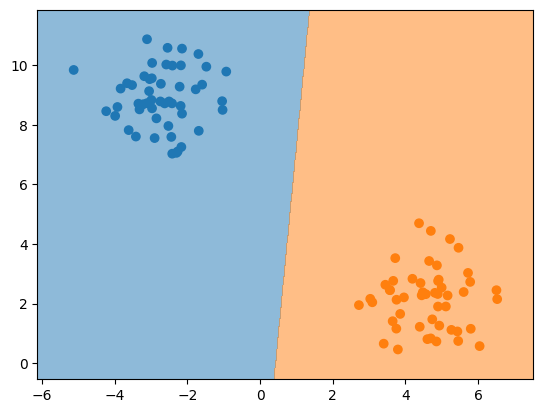

In [14]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)

ml = z3Linear(NUM_FEATURES)
terms = train(X, y, ml, threshold_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

sat
Model Parameters:
 w: [1 0]
 b: [0]


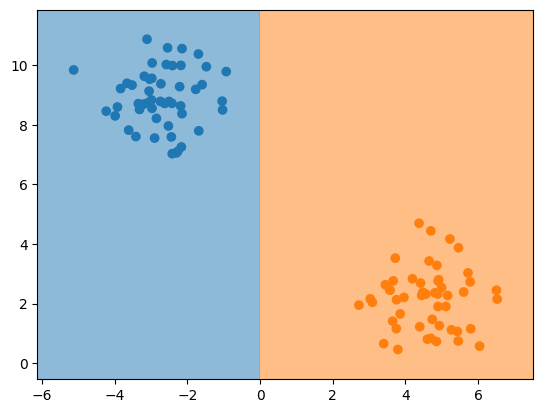

In [15]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)

ml = z3Linear(NUM_FEATURES, dtype=Int)
terms = train(X, y, ml, threshold_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

sat
Model Parameters:
 w: [[-0.62387299  0.31525252 -0.1829057 ]
 [ 0.24578263 -0.31134908 -0.03921091]]
 b: [-4.20721978 -1.48808078 -1.74238036]
CPU times: user 3.48 s, sys: 193 ms, total: 3.67 s
Wall time: 1.73 s


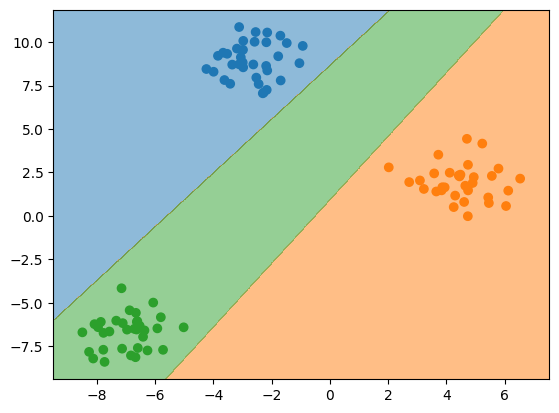

In [15]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=seed)

ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
terms = train(X, y, ml, multiclass_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

sat
Model Parameters:
 w: [[92864220445759437500000000002 144122933287490029826439289602 1]
 [-4873357652740001713853629610 -1 8608463570288997]]
 b: [-514332033854434 1 -434387443111796314234944673694]
CPU times: user 2.45 s, sys: 432 ms, total: 2.88 s
Wall time: 3.29 s


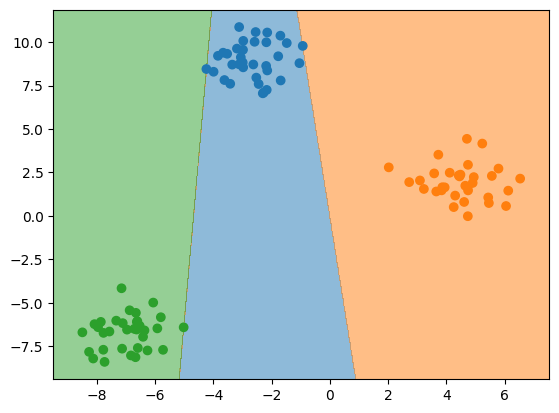

In [16]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=seed)

ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES, dtype=Int)
terms = train(X, y, ml, multiclass_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred)
  plot(X, y)

## Try to pass in quantized input

In [18]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)
ml = z3Linear(NUM_FEATURES)
Xq, Xd = quantize_X(X)

In [19]:
display(X[0])
display(Xq[0])
display(Xd[0])

array([-2.98837186,  8.82862715])

array([-117.,  207.])

array([-2.99431206,  8.82109338])

sat
Model Parameters:
 w: [ 0.00331795 -0.0033698 ]
 b: [0.30330758]
CPU times: user 57.4 ms, sys: 7.48 ms, total: 64.8 ms
Wall time: 63.6 ms


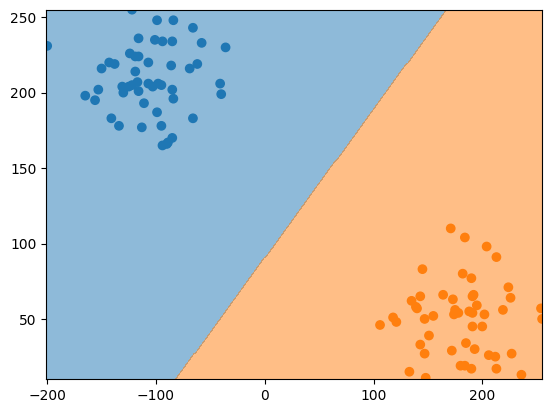

In [20]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)
ml = z3Linear(NUM_FEATURES)
Xq, Xd = quantize_X(X)

terms = train(Xq, y, ml, threshold_loss)
s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(Xq, y, ml.pred, h = 1)
  plot(Xq, y)

sat
Model Parameters:
 w: [ 0.01176471 -0.01764706]
 b: [0.48235294]
CPU times: user 46.9 ms, sys: 1.74 ms, total: 48.6 ms
Wall time: 47.9 ms


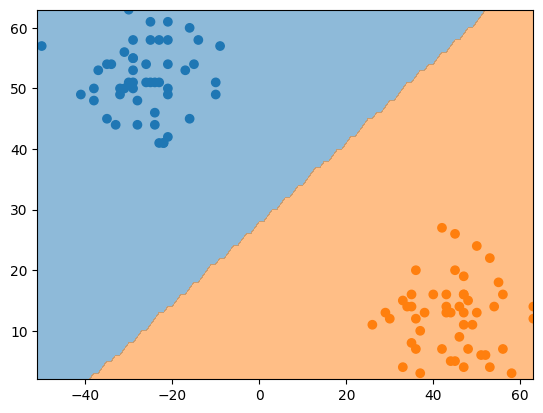

In [21]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=2, random_state=seed)
ml = z3Linear(NUM_FEATURES)
Xq, Xd = quantize_X(X, b=6)

terms = train(Xq, y, ml, threshold_loss)
s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(Xq, y, ml.pred, h = 1)
  plot(Xq, y)

sat
Model Parameters:
 w: [ 0.12992778 -0.07824544]
 b: [0.29876946]
CPU times: user 131 ms, sys: 2.53 ms, total: 134 ms
Wall time: 134 ms


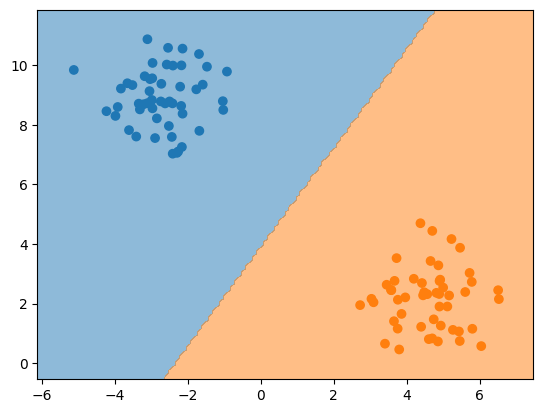

In [22]:
%%time
ml = z3Linear(NUM_FEATURES)
terms = train(X, y, ml, threshold_loss)
s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred, h = 0.1)
  plot(X, y)

sat
Model Parameters:
 w: [[-0.00720425  0.0027525  -0.00100591]
 [ 0.00595033 -0.00245212 -0.00231414]]
 b: [-1.08428318 -0.26969616 -0.37767161]
CPU times: user 375 ms, sys: 6.68 ms, total: 382 ms
Wall time: 552 ms


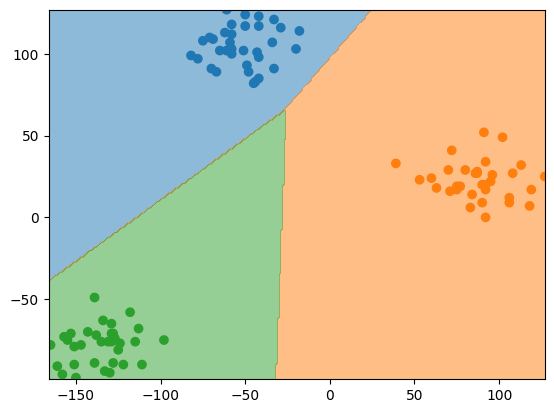

In [23]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=seed)
Xq, Xd = quantize_X(X, b=7)

ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
terms = train(Xq, y, ml, multiclass_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(Xq, y, ml.pred, h=1)
  plot(Xq, y)

sat
Model Parameters:
 w: [[-0.09825141  0.16848823 -0.1838825 ]
 [ 0.07373409  0.043235    0.0109253 ]]
 b: [-0.99732404 -0.95092664 -1.32903618]
CPU times: user 2.17 s, sys: 149 ms, total: 2.32 s
Wall time: 2.54 s


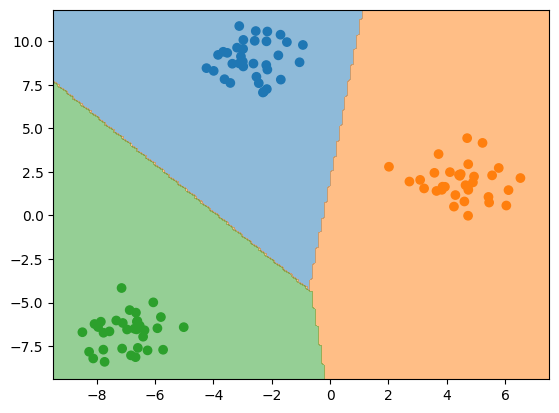

In [58]:
%%time
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=seed)

ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
terms = train(X, y, ml, multiclass_loss)

s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  m = s.model()
  ml = ml.realize(m)
  print("Model Parameters:")
  print(f" w: {ml.w}")
  print(f" b: {ml.b}")

  plot_boundry(X, y, ml.pred, h=0.1)
  plot(X, y)

# Not Linearly Separable

## XOR

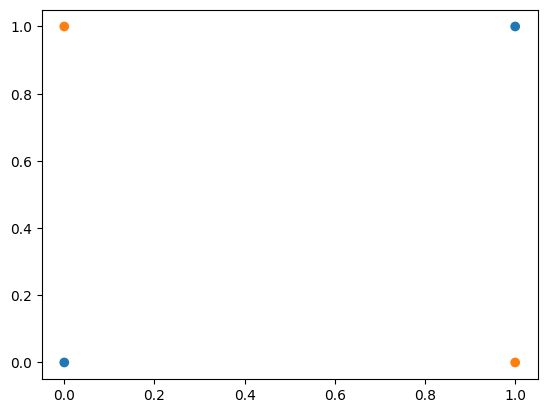

In [25]:
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]])
y = np.array([0, 1, 1, 0])

plot(X, y)

In [26]:
ml = z3Linear(2)
terms = train(X, y, ml, threshold_loss)

s = Solver()
s.add(*itertools.chain(*terms))
print(s.check(), "as expected")

unsat as expected


In [27]:
ml = z3MLP(2, 3, 2, dtype=Int)  # This takes forwver with a dtype of Real
terms = train(X, y, ml, multiclass_loss)

sat
Model Parameters:
 ws: [array([[-1,  1,  0],
       [ 1,  0, -1]]), array([[ 0,  5],
       [-7, -4],
       [-2,  0]])]
 bs: [array([0, 0, 2]), array([ 3, -3])]
CPU times: user 125 ms, sys: 6.59 ms, total: 132 ms
Wall time: 124 ms


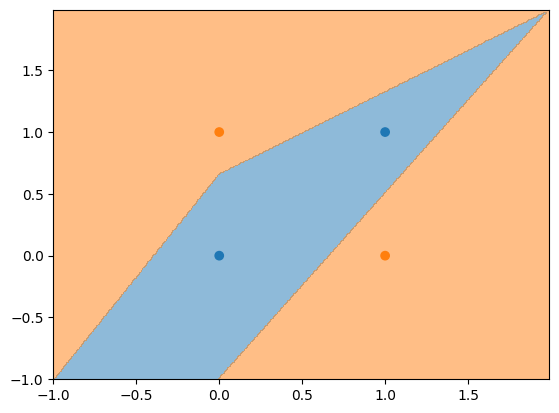

In [28]:
%%time
s = Solver()
s.add(*itertools.chain(*terms))
status = s.check()
print(status)
if status == sat:
  ml = ml.realize(s.model())

  print("Model Parameters:")
  print(f" ws: {ml.ws}")
  print(f" bs: {ml.bs}")
  plot_boundry(X, y, ml.pred)
  plot(X, y)

## More Realistic Non-separable

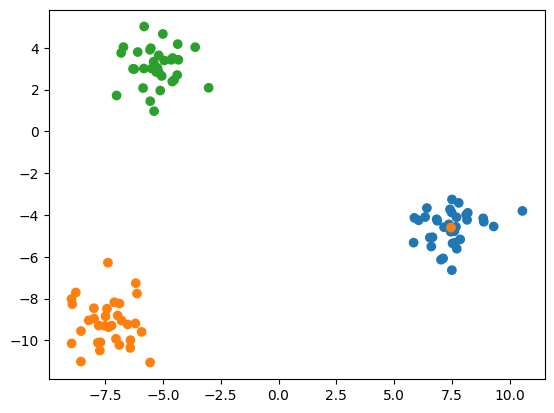

In [29]:
X, y = make_blobs(n_features=NUM_FEATURES, centers=NUM_CLASSES, random_state=128)

# Create a datapoint in the wrong cluster
X_ns = np.concatenate([X, np.mean(X[y == 0], axis=0, keepdims=True)], axis=0)
y_ns = np.concatenate([y, [1]], axis=0)

plot(X_ns, y_ns)

In [30]:
ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
terms = train(X_ns, y_ns, ml, multiclass_loss)

s = Solver()
s.set(unsat_core=True)
for i, ts in enumerate(terms):
  for j, t in enumerate(ts):
    if j == (len(ts) - 1):
      s.assert_and_track(t, f"d{i}")
    else:
      s.add(t)
print(s.check(), "as expected")

unsat as expected


In [31]:
def plot_unsat(x, y, unsat):
    plt.scatter(*x.T, color=COLORS[y])
    plt.scatter(*x[unsat].T, color=COLORS[y[unsat]], edgecolor="k")

There are 4 constraints in the UNSAT-core: [d100, d0, d32, d3]


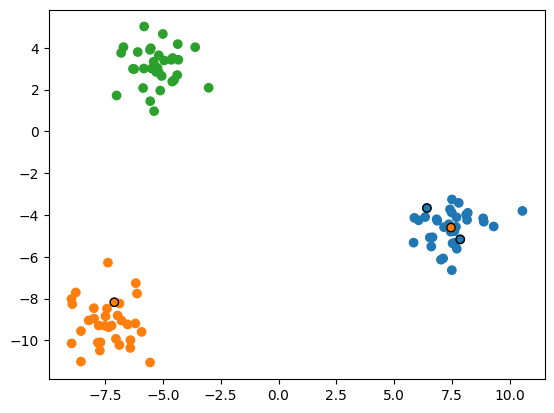

In [32]:
c = s.unsat_core()
print(f"There are {len(c)} constraints in the UNSAT-core: {c}")

unsat = [int(str(u)[1:]) for u in c]

plot_unsat(X_ns, y_ns, unsat)

In [33]:
def plot_max(x, y, y_pred):
    plt.scatter(*x.T, color=COLORS[y])
    plt.scatter(*x[y != y_pred].T, color=COLORS[y[y != y_pred]], edgecolor=COLORS[y_pred[y != y_pred]])

sat
Model Accuracy: 99.0099


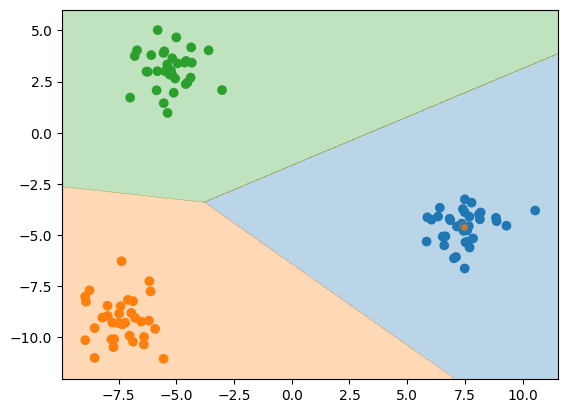

In [34]:
o = Optimize()  # A MaxSAT solver, it takes longer
for i, ts in enumerate(terms):
    for j, t in enumerate(ts):
        if j == (len(ts) - 1):
            o.add_soft(t)
        else:
            o.add(t)
status = o.check()
print(status)
if status == sat:
    ml = ml.realize(o.model())
    y_hat = ml.pred(X_ns)
    print(f"Model Accuracy: {sum(y_hat == y_ns)/len(y_ns)*100:.4f}")

    plot_max(X_ns, y_ns, y_hat)
    plot_boundry(X_ns, y_ns, ml.pred, alpha=0.3)

# Simple Scaling

In [35]:
# times = []
# num_examples = [2 ** i for i in range(16)]

# for num_ex in num_examples:
#     status = unsat
#     while status == unsat:
#         X, y = make_blobs(num_ex, n_features=NUM_FEATURES, centers=NUM_CLASSES)
#         ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
#         terms = train(X, y, ml, multiclass_loss)
#         s = Solver()
#         s.add(*itertools.chain(*terms))
#         tic = time.time()
#         status = s.check()
#         toc = time.time()
#     times.append(toc - tic)
#     print(f"Solved for {num_ex} examples.")

In [36]:
# plt.plot(num_examples, times)
# plt.xscale("log")
# plt.ylabel("seconds")
# plt.xlabel("Number of Examples");

In [16]:
times_noquant = []
times_quant = []
num_examples = [2 ** i for i in range(12)]

for num_ex in num_examples:
    status = unsat
    while status == unsat:
        X, y = make_blobs(num_ex, n_features=NUM_FEATURES, centers=NUM_CLASSES)
        ml = z3MultiClassLinear(NUM_FEATURES, NUM_CLASSES)
        Xq, _ = quantize_X(X)
        terms1 = train(X, y, ml, multiclass_loss)
        terms2 = train(Xq, y, ml, multiclass_loss)

        # check without quant
        s = Solver()
        s.add(*itertools.chain(*terms1))
        tic1 = time.time()
        status = s.check()
        print(f"status no quant: {status}")
        toc1 = time.time()
        
        # check with quant
        s = Solver()
        s.add(*itertools.chain(*terms2))
        tic2 = time.time()
        status = s.check()
        print(f"status quant: {status}")
        toc2 = time.time()
    
    times_noquant.append(toc1 - tic1)
    times_quant.append(toc2 - tic2)
    
    print(f"Solved for {num_ex} examples.")

status no quant: sat
status quant: sat
Solved for 1 examples.
status no quant: sat
status quant: sat
Solved for 2 examples.
status no quant: sat
status quant: sat
Solved for 4 examples.
status no quant: sat
status quant: sat
Solved for 8 examples.
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 16 examples.
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 32 examples.
status no quant: sat
status quant: sat
Solved for 64 examples.
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 128 examples.
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 256 examples.
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 512 examples.
status no quant: sat
status quant: sat
Solved for 1024 examples.
status no quant: sat
status quant: sat
Solved fo

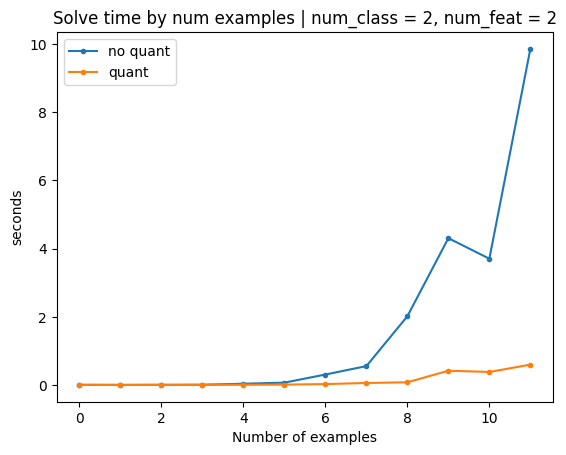

In [17]:
plt.plot(times_noquant, label='no quant', marker='.')
plt.plot(times_quant, label = 'quant', marker = '.')
plt.ylabel("seconds")
plt.xlabel("Number of examples")
plt.title("Solve time by num examples | num_class = 2, num_feat = 2")
plt.legend()

In [49]:
times_noquant = []
times_quant = []
num_ex = 50
num_features = [2**i for i in range(5)]

for num_feat in num_features:
    status = unsat
    while status == unsat:
        X, y = make_blobs(num_ex, n_features=num_feat, centers=NUM_CLASSES)
        ml = z3MultiClassLinear(num_feat, NUM_CLASSES)
        Xq, _ = quantize_X(X)
        terms1 = train(X, y, ml, multiclass_loss)
        terms2 = train(Xq, y, ml, multiclass_loss)

        # check without quant
        s = Solver()
        s.add(*itertools.chain(*terms1))
        tic1 = time.time()
        status = s.check()
        print(f"status no quant: {status}")
        toc1 = time.time()
        
        # check with quant
        s = Solver()
        s.add(*itertools.chain(*terms2))
        tic2 = time.time()
        status = s.check()
        print(f"status quant: {status}")
        toc2 = time.time()
    
    times_noquant.append(toc1 - tic1)
    times_quant.append(toc2 - tic2)
    
    print(f"Solved for {num_feat} features.")

status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 1 features.
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 2 features.
status no quant: sat
status quant: sat
Solved for 4 features.
status no quant: sat
status quant: sat
Solved for 8 features.
status no quant: sat
status quant: sat
Solved for 16 features.


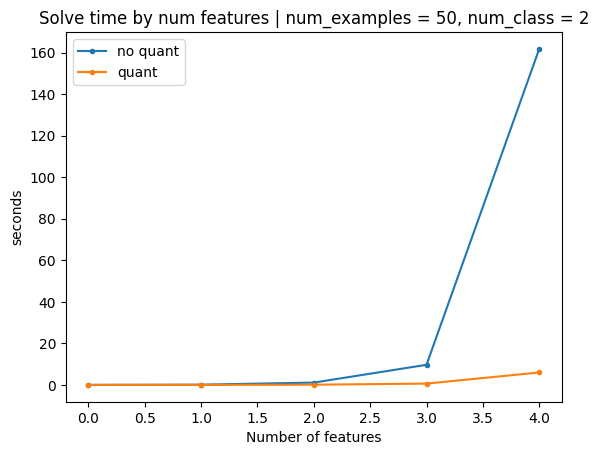

In [50]:
plt.plot(times_noquant, label='no quant',marker='.')
plt.plot(times_quant, label = 'quant',marker='.')
plt.ylabel("seconds")
plt.xlabel("Number of features")
plt.title("Solve time by num features | num_examples = 50, num_class = 2")
plt.legend()

In [56]:
# with increased # classes, harder to separate
times_noquant = []
times_quant = []
num_ex = 50
num_classes = [2**i for i in range(5)]

for num_class in num_classes:
    status = unsat
    while status == unsat:
        X, y = make_blobs(num_ex, n_features=NUM_FEATURES, centers=num_class)
        ml = z3MultiClassLinear(NUM_FEATURES, num_class)
        Xq, _ = quantize_X(X)
        terms1 = train(X, y, ml, multiclass_loss)
        terms2 = train(Xq, y, ml, multiclass_loss)

        # check without quant
        s = Solver()
        s.add(*itertools.chain(*terms1))
        tic1 = time.time()
        status = s.check()
        print(f"status no quant: {status}")
        toc1 = time.time()
        
        # check with quant
        s = Solver()
        s.add(*itertools.chain(*terms2))
        tic2 = time.time()
        status = s.check()
        print(f"status quant: {status}")
        toc2 = time.time()
    
    times_noquant.append(toc1 - tic1)
    times_quant.append(toc2 - tic2)
    
    print(f"Solved for {num_class} classes.")

status no quant: sat
status quant: sat
Solved for 1 classes.
status no quant: sat
status quant: sat
Solved for 2 classes.
status no quant: sat
status quant: sat
Solved for 4 classes.
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: unsat
status quant: unsat
status no quant: sat
status quant: sat
Solved for 8 classes.
status no quant: sat
status quant: sat
Solved for 16 classes.


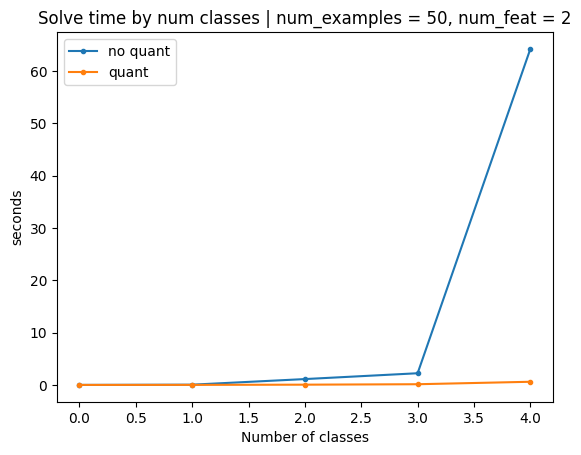

In [57]:
plt.plot(times_noquant, label='no quant', marker='.')
plt.plot(times_quant, label = 'quant', marker='.')
plt.ylabel("seconds")
plt.xlabel("Number of classes")
plt.title("Solve time by num classes | num_examples = 50, num_feat = 2")
plt.legend()

**Some observations**

* Quantization (to int 2**8 range) helps a lot for scaling #classes/#features/#examples
* **Scaling # features** is the slowest (using the non-quantized original data); scaling # features with fixed num class = 2 does not result in any unsat instances.
* **Scaling # classes** result in a few "unsat" instances as # classes go up (random data generation produces overlapping classes). Highlights the need for handling non separable data samples (Optimize() etc).
* **Scaling # examples** is the fastest. Probably because the examples are in blobs.

Just testing on # features 50 and # example 10 (input quantized) -- taking forever. Makes me think that realistic data could take quite long to solve? But I'm going to try with MNIST/CIFAR (or tabular data if I can't get them to work).

In [ ]:
times = []
num_ex = 100
num_features = [50] #[i for i in range(50, 110, 10)]

for num_feat in num_features:
    status = unsat
    while status == unsat:
        X, y = make_blobs(num_ex, n_features=num_feat, centers=2)
        ml = z3MultiClassLinear(num_feat, NUM_CLASSES)
        Xq, _ = quantize_X(X)
        terms2 = train(Xq, y, ml, multiclass_loss)
        
        # check with quant
        s = Solver()
        s.add(*itertools.chain(*terms2))
        tic2 = time.time()
        status = s.check()
        print(f"status quant: {status}")
        toc2 = time.time()
    
    times.append(toc2 - tic2)
    
    print(f"Solved for {num_feat} features.")

## Actual data for multi-class classification

In [71]:
import torchvision

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
train_data = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)